In [1]:
import os
import SimpleITK as sitk
import numpy as np
import glob
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from scipy.stats import skew


In [2]:
def nii_to_arr(nii_file):
    '''
    Converts nifti file to array. 
    Returns origin, spacing and the array.
    '''
    sitk_img = sitk.ReadImage(nii_file)
    origin = sitk_img.GetOrigin()
    spacing = sitk_img.GetSpacing()
    assert(spacing[2] == 12.)
    arr = sitk.GetArrayFromImage(sitk_img)
    
    return origin, spacing, arr

def arr_to_nii(origin, spacing, arr, nii_file):
    '''
    Converts array to nifti file.
    '''
    assert(spacing[2] == 12.)
    out = sitk.GetImageFromArray(arr)
    out.SetOrigin(origin)
    out.SetSpacing(spacing)
    sitk.WriteImage(out, nii_file)    
    
def extract_chamber(segmentation_file, intensity):
    '''
    Extracts LV and LVMC from segmented image.
    '''
    origin, spacing, img_arr = nii_to_arr(segmentation_file)
    assert(spacing[2] == 12.)
    img_arr_roi = np.where(img_arr == intensity, 1., 0.)
    return origin, spacing, img_arr_roi

def extract_voxel(nii_file):
    '''
    Returns voxel volume.
    '''
    sitk_img = sitk.ReadImage(nii_file)
    assert(sitk_img.GetSpacing()[2] == 12.)
    return sitk_img.GetSpacing()[0]*sitk_img.GetSpacing()[1]*sitk_img.GetSpacing()[2]

In [3]:
# dictionary containing intensity values of LV and LVMC in the masks
chamber_volume_nnunet = {}
chamber_intensity = {'LV': 3.,
                    'LVMC': 2., 
                    }
nnunet_images_suffix = '.nii.gz'

In [4]:
# path to raw images and masks
nnunet_path = '/Volumes/PENDRIVE/sample/uh_images/'
raw_image_path = '/Volumes/PENDRIVE/raw_uh_images/'

### Volume Features

In [5]:
cwd_path = os.getcwd()
cwd_path

'/Users/saurabh/Desktop/HeartProjects/Exhalted/Params/Code_EXH/unexplained_dyspnea'

In [6]:
# extracting patient ids
patient_dirs = glob.glob(nnunet_path+'*')
patient_ids = sorted([re.search('(EXH)(.+)',dir_name).group(2) for dir_name in patient_dirs])
print(len(patient_ids))

57


In [7]:
def chamber_vol_func(patient_id, noise_type):
    '''
    Calculates LV and Myocardial volume
    '''
    nnunet_folder = f'{nnunet_path}EXH{patient_id}/REST/z_12/all_slices/'
    nnunet_images_prefix = f'EXH{patient_id}_CINE_SET-UP-8SAX-1RTVLA-1HLA_'

    # patient '100B' has a different sequence name
    if patient_id == '100B':
        nnunet_images_prefix = f'EXH{patient_id}_CINE_SET-UP-8SAX-1VLA-1HLA_'

    num_images = len(glob.glob(nnunet_folder+'*.gz'))
    comp_dict = {
        'LV': '_lv_',
        'LVMC': '_lvmc_'
    }
    
    for comp in ['LV','LVMC']:
        vol = []
        for t in range(num_images):
            if noise_type is None:
                rest_maskName = nnunet_folder + nnunet_images_prefix + str(t).zfill(4) + nnunet_images_suffix
                origin, spacing, rest_chamber = extract_chamber(rest_maskName, chamber_intensity[comp])
            else:
                rest_maskName = f'{nnunet_path}EXH{patient_id}/REST/z_12/{noise_type}/' \
                + nnunet_images_prefix + str(t).zfill(4) + comp_dict[comp] + nnunet_images_suffix
                origin, spacing, rest_chamber = nii_to_arr(rest_maskName)                
            voxel_vol = extract_voxel(rest_maskName)
            vol.append(np.sum(rest_chamber)*voxel_vol)
        chamber_volume_nnunet[comp] = vol
    return chamber_volume_nnunet

#### Plot volume vs time

max volume =  136728.75 
min volume =  67619.81
ejection fraction =  0.51


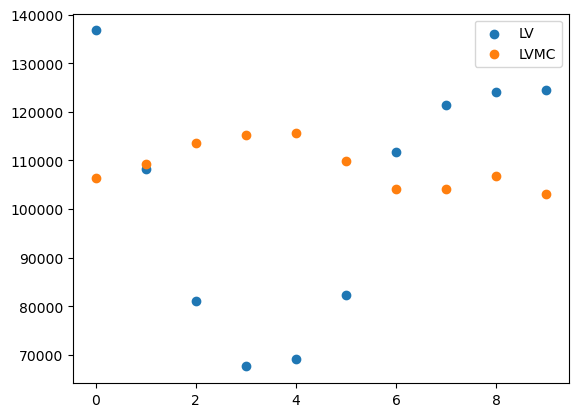

In [8]:
# looking at the time curve of volume for a patient
patient_id = '134'

chamber_volume_nnunet = chamber_vol_func(patient_id, None)
nnunet_folder = f'{nnunet_path}EXH{patient_id}/REST/z_12/all_slices/'
num_images = len(glob.glob(nnunet_folder+'*.gz'))

plt.scatter(np.arange(num_images),chamber_volume_nnunet['LV'],label='LV')
plt.scatter(np.arange(num_images),chamber_volume_nnunet['LVMC'],label='LVMC')
plt.legend();

es_vol = min(chamber_volume_nnunet['LV'])
ed_vol = max(chamber_volume_nnunet['LV'])
print('max volume = ', round(ed_vol,2), '\nmin volume = ', round(es_vol,2))
print('ejection fraction = ', round(1 - (es_vol/ed_vol),2))

In [9]:
# class extracting LVMC features
class lvmcFeatures:
    def __init__(self, lvmc_volume, es, ed):
        self.vol = lvmc_volume
        self.vol_es = lvmc_volume[es]
        self.vol_ed = lvmc_volume[ed]
        self.vol_max = max(self.vol)
        self.vol_min = min(self.vol)
        
    def lvmc_std(self):
        return np.std(self.vol)/np.sqrt(len(self.vol))
    def lvmc_snr(self):
        return np.mean(self.vol)/np.std(self.vol)
    def lvmc_vol_es(self):
        return self.vol_es
    def lvmc_vol_ed(self):
        return self.vol_ed
    def lvmc_vol_max(self):
        return self.vol_max
    def lvmc_vol_min(self):
        return self.vol_min
    def lvmc_vol_es_equal_max(self):
        return int(self.vol_max == self.vol_es)
    def lvmc_vol_max_minus_min(self):
        return (self.vol_max - self.vol_min)/self.vol_max

In [10]:
# class extracting LV features
class lvFeatures:
    def __init__(self, lv_volume, es, ed):
        self.vol = lv_volume
        self.vol_es = lv_volume[es]
        self.vol_ed = lv_volume[ed]
        
    def lv_std(self):
        return np.std(self.vol)/np.sqrt(len(self.vol))
    def lv_snr(self):
        return np.mean(self.vol)/np.std(self.vol)
    def lv_vol_es(self):
        return self.vol_es
    def lv_vol_ed(self):
        return self.vol_ed
    def stroke_volume(self):
        return self.vol_ed - self.vol_es
    def ejection_fraction(self):
        return (self.vol_ed - self.vol_es)/self.vol_ed

In [11]:
def extract_vol_features(noise_type):
    '''
    Returns volume features from masks
    '''
    vol_data = []
    for patient_id in patient_ids:

        nnunet_folder = f'{nnunet_path}EXH{patient_id}/REST/z_12/all_slices/'
        num_images = len(glob.glob(nnunet_folder+'*.gz'))
        print(f'Patient Id={patient_id}',f'number of images={num_images}')

        chamber_volume_nnunet = chamber_vol_func(patient_id, noise_type)
        es = chamber_volume_nnunet['LV'].index(min(chamber_volume_nnunet['LV']))
        ed = chamber_volume_nnunet['LV'].index(max(chamber_volume_nnunet['LV']))

        vol_list = [patient_id]
        lvmc_features = lvmcFeatures(chamber_volume_nnunet['LVMC'],es,ed)

        vol_list.extend([lvmc_features.lvmc_std(), lvmc_features.lvmc_snr(), lvmc_features.lvmc_vol_es(), \
                   lvmc_features.lvmc_vol_ed(), lvmc_features.lvmc_vol_max(), lvmc_features.lvmc_vol_min(),\
                   lvmc_features.lvmc_vol_es_equal_max(), lvmc_features.lvmc_vol_max_minus_min()])

        lv_features = lvFeatures(chamber_volume_nnunet['LV'],es,ed)
        vol_list.extend([lv_features.lv_std(), lv_features.lv_snr(), lv_features.lv_vol_es(), \
                   lv_features.lv_vol_ed(), lv_features.stroke_volume(), lv_features.ejection_fraction()])

        vol_data.append(vol_list)
        
    return vol_data

In [12]:
vol_data = []
# noise_type = None refers to original masks. To check stability of features, we introduce
# noise such as expansion and randomized contouring in masks and re-extarct features
# and compare them with original values.
noise_type = None 
for patient_id in patient_ids:

    nnunet_folder = f'{nnunet_path}EXH{patient_id}/REST/z_12/all_slices/'
    num_images = len(glob.glob(nnunet_folder+'*.gz'))
    print(f'Patient Id={patient_id}',f'number of images={num_images}')
    
    chamber_volume_nnunet = chamber_vol_func(patient_id, noise_type)
    es = chamber_volume_nnunet['LV'].index(min(chamber_volume_nnunet['LV']))
    ed = chamber_volume_nnunet['LV'].index(max(chamber_volume_nnunet['LV']))
    
    vol_list = [patient_id]
    lvmc_features = lvmcFeatures(chamber_volume_nnunet['LVMC'],es,ed)

    vol_list.extend([lvmc_features.lvmc_std(), lvmc_features.lvmc_snr(), lvmc_features.lvmc_vol_es(), \
               lvmc_features.lvmc_vol_ed(), lvmc_features.lvmc_vol_max(), lvmc_features.lvmc_vol_min(),\
               lvmc_features.lvmc_vol_es_equal_max(), lvmc_features.lvmc_vol_max_minus_min()])
    
    lv_features = lvFeatures(chamber_volume_nnunet['LV'],es,ed)
    vol_list.extend([lv_features.lv_std(), lv_features.lv_snr(), lv_features.lv_vol_es(), \
               lv_features.lv_vol_ed(), lv_features.stroke_volume(), lv_features.ejection_fraction()])
    
    vol_data.append(vol_list)

Patient Id=100B number of images=17
Patient Id=101B number of images=10
Patient Id=103 number of images=10
Patient Id=105B number of images=10
Patient Id=109 number of images=7
Patient Id=111 number of images=24
Patient Id=113B number of images=8
Patient Id=114 number of images=25
Patient Id=119 number of images=15
Patient Id=121 number of images=15
Patient Id=123 number of images=21
Patient Id=124 number of images=9
Patient Id=126 number of images=12
Patient Id=129 number of images=10
Patient Id=130 number of images=12
Patient Id=132 number of images=13
Patient Id=133 number of images=10
Patient Id=134 number of images=10
Patient Id=135 number of images=12
Patient Id=136A number of images=9
Patient Id=141 number of images=8
Patient Id=142 number of images=10
Patient Id=143 number of images=8
Patient Id=146 number of images=6
Patient Id=147 number of images=7
Patient Id=149 number of images=8
Patient Id=150 number of images=12
Patient Id=151 number of images=9
Patient Id=153 number of 

In [13]:
# making sure we are extracting data for all patients
assert len(vol_data) == len(patient_ids)

In [14]:
# saving data contained in list to a dataframe
vol_df = pd.DataFrame()
vol_df = pd.DataFrame(data=vol_data, columns=['patient_id', 'lvmc_std', 'lvmc_snr', 'lvmc_vol_es', \
        'lvmc_vol_ed', 'lvmc_vol_max', 'lvmc_vol_min','lvmc_vol_es_equal_max', 'lvmc_vol_max_minus_min',\
        'lv_std', 'lv_snr', 'lv_vol_es', 'lv_vol_ed', 'stroke_volume', 'ejection_fraction'])

In [15]:
vol_df.shape

(57, 15)

In [16]:
vol_df.head()

,patient_id,lvmc_std,lvmc_snr,lvmc_vol_es,lvmc_vol_ed,lvmc_vol_max,lvmc_vol_min,lvmc_vol_es_equal_max,lvmc_vol_max_minus_min,lv_std,lv_snr,lv_vol_es,lv_vol_ed,stroke_volume,ejection_fraction
0,100B,2250.174975,14.478556,122988.1875,139436.2500,148709.4375,118114.6875,0,0.205735,2168.140010,20.616114,164954.4375,196361.4375,31407.0000,0.159945
1,101B,3389.251079,10.381979,136187.2500,123462.0000,136187.2500,96996.1875,1,0.287773,9517.657049,2.837491,39867.9375,133344.3750,93476.4375,0.701015
2,103,3343.955006,14.820243,175513.6875,144242.0625,175513.6875,144242.0625,1,0.178172,10586.318292,4.654657,104983.3125,203333.2500,98349.9375,0.483688
3,105B,2464.666301,20.048423,156019.6875,153582.9375,176055.1875,148777.1250,0,0.154940,10604.243561,5.340548,123597.3750,226617.7500,103020.3750,0.454600
4,109,2522.159368,18.556770,111413.6250,126507.9375,135239.6250,111413.6250,0,0.176176,15817.902632,2.284888,42440.0625,153447.5625,111007.5000,0.723423


In [17]:
vol_df.describe().T

,count,mean,std,min,25%,50%,75%,max
lvmc_std,57.0,1780.388646,965.513941,628.804706,1153.427697,1576.147548,2147.494534,5227.582422
lvmc_snr,57.0,23.673666,9.338710,6.836636,16.490328,22.998410,29.353887,51.752073
lvmc_vol_es,57.0,119445.798885,34100.139328,66739.875000,99432.937500,111481.312500,136187.250000,245279.123421
lvmc_vol_ed,57.0,116725.553853,26379.545589,65995.312500,101531.250000,112293.562500,131003.510365,200697.419636
lvmc_vol_max,57.0,127558.325442,32738.120539,71816.437500,109586.062500,122446.687500,143159.062500,249944.650562
lvmc_vol_min,57.0,108747.613617,27844.554100,59294.250000,91613.147363,106018.453125,128538.562500,200697.419636
lvmc_vol_es_equal_max,57.0,0.192982,0.398147,0.000000,0.000000,0.000000,0.000000,1.000000
lvmc_vol_max_minus_min,57.0,0.146202,0.055944,0.051396,0.107206,0.135528,0.180286,0.319470
lv_std,57.0,8723.386003,3067.369561,1293.227392,7026.437692,9064.454540,10604.243561,15817.902632
lv_snr,57.0,4.626109,3.411217,2.119069,3.227912,3.573549,4.431670,20.616114


In [18]:
# saving volume features in csv file for further analysis
vol_df.to_csv('vol.csv')

In [80]:
def non_zero_stacks(patient_id):
    nnunet_folder = f'{nnunet_path}EXH{patient_id}/REST/z_12/all_slices/'
    nnunet_images_prefix = f'EXH{patient_id}_CINE_SET-UP-8SAX-1RTVLA-1HLA_'

    if patient_id == '100B':
        nnunet_images_prefix = f'EXH{patient_id}_CINE_SET-UP-8SAX-1VLA-1HLA_'

    chamber_volume_nnunet = chamber_vol_func(patient_id)
    ed = chamber_volume_nnunet['LV'].index(max(chamber_volume_nnunet['LV']))

    rest_maskName = nnunet_folder + nnunet_images_prefix + str(ed).zfill(4) + nnunet_images_suffix
    _, _, rest_chamber = extract_chamber(rest_maskName, chamber_intensity['LV'])

    lv_slices = 0
    for slices in range(rest_chamber.shape[0]):
        if np.sum(rest_chamber[slices, :, :]) > 0:
            lv_slices += 1
    return lv_slices

In [84]:
non_zero_stacks_list = []
for patient in patient_ids:
    non_zero_stacks_list.append(non_zero_stacks(patient))

In [126]:
sphericity_index_list = []
for ind, patient in enumerate(patient_ids):
    numerator = vol_df[vol_df['patient_id']== patient]['lv_vol_ed'].values[0]
    denominator = ((12.*non_zero_stacks_list[ind]/2)**3)*(4.*np.pi/3.)
    sphericity_index_list.append([patient,numerator/denominator])

In [127]:
sphericity_index_df = pd.DataFrame()
sphericity_index_df = pd.DataFrame(data=sphericity_index_list, columns=['patient_id', 'sphericity_index'])
sphericity_index_df.head()

,patient_id,sphericity_index
0,100B,0.326234
1,101B,0.429673
2,103,0.655197
3,105B,0.489195
4,109,0.331244


In [128]:
sphericity_index_df.to_csv('sphericity_index.csv')

### 3D features: Pyradiomics

In [19]:
from radiomics import featureextractor
extractor = featureextractor.RadiomicsFeatureExtractor()

In [21]:
# making a list of all 3D pyradiomics features we are extracting
pyrads_3d_columns = ['original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume',
       'original_shape_MinorAxisLength', 'original_shape_Sphericity',
       'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio',
       'original_shape_VoxelVolume']

In [22]:
def extract_roi(mask_arr, raw_file):
    '''
    returns origin, spacing and ROI from raw images
    '''
    origin, spacing, raw_arr_roi = nii_to_arr(raw_file)
    assert spacing[2] == 12.
    roi = np.multiply(mask_arr, raw_arr_roi)
    
    return origin, spacing, roi

In [23]:
def lv_pyrads_3d_stats(pyrads_3d_features, es, ed):
    '''
    returns statistical values of pyrads features calculated over a cardiac cycle
    '''
    min_val = np.amin(pyrads_3d_features, axis = 0)
    max_val = np.amax(pyrads_3d_features, axis = 0)
    mean_val = np.mean(pyrads_3d_features, axis = 0)
    median = np.median(pyrads_3d_features, axis = 0)
    std_dev = np.std(pyrads_3d_features, axis = 0)
    snr = mean_val/std_dev
    es_val = pyrads_3d_features[es]
    ed_val = pyrads_3d_features[ed]

    return min_val, max_val, mean_val, median, std_dev, snr ,es_val, ed_val

In [24]:
def lv_pyrads_3d_func(patient_id, noise_type):
    '''
    returns pyrads features for each patient
    '''
    shape_first = 22
    shape_last = 35

    comp = 'LV'
    nnunet_folder = nnunet_path + 'EXH' + patient_id + '/REST/z_12/all_slices/'
    num_images = len(glob.glob(nnunet_folder+'*.gz'))
    print('number of images = ',num_images)
    pyrads_3d_features = np.zeros((num_images, shape_last-shape_first+2))
    
    raw_images_prefix = 'CINE_SET-UP-8SAX-1RTVLA-1HLA'
    raw_images_suffix = '__0000.nii.nii'
    if patient_id in ['200', '111', '135', '187', '190']:
        raw_images_suffix = '__0000.nii'

    if patient_id == '100B':
        raw_images_prefix = 'CINE_SET-UP-8SAX-1VLA-1HLA'
    
    nnunet_images_prefix = raw_images_prefix
    comp_dict = {
        'LV': '_lv_',
        'LVMC': '_lvmc_'
    }
    
    for t in range(num_images):
        raw_file = raw_image_path + f'/EXH{patient_id}/' + raw_images_prefix + \
        f'/EXH{patient_id}_3D/normalized/EXH{patient_id}_{raw_images_prefix}_' + \
        str(t).zfill(4) + raw_images_suffix
        
        if noise_type is None:
            mask_file = nnunet_folder + f'/EXH{patient_id}_{nnunet_images_prefix}_' + \
            str(t).zfill(4) + nnunet_images_suffix
            origin, spacing, mask_arr = extract_chamber(mask_file, chamber_intensity['LV'])
            components_path = f'{nnunet_path}EXH{patient_id}/REST/z_12/components/'
        else:
            mask_file = f'{nnunet_path}EXH{patient_id}/REST/z_12/{noise_type}/' \
        + f'/EXH{patient_id}_{nnunet_images_prefix}_' + str(t).zfill(4) + comp_dict[comp] + nnunet_images_suffix        
            origin, spacing, mask_arr = nii_to_arr(mask_file)
            components_path = f'{nnunet_path}EXH{patient_id}/REST/z_12/{noise_type}/components/'

        _, roi_spacing, roi_arr = extract_roi(mask_arr, raw_file)

        assert spacing[2] == 12.
        assert roi_spacing[2] == 12.

        if not os.path.isdir(components_path):
            os.mkdir(components_path)

        roi_nii = f'{components_path}roi_{str(t)}.nii.gz'
        mask_nii = f'{components_path}mask_{str(t)}.nii.gz'
        arr_to_nii(origin, spacing, roi_arr, roi_nii)          
        arr_to_nii(origin, spacing, mask_arr, mask_nii)  
        result = extractor.execute(os.path.join(roi_nii),os.path.join(mask_nii));
        
        for ind, shape_feature in enumerate(pyrads_3d_columns):
            pyrads_3d_features[t, ind] = result[shape_feature]
            
        pyrads_3d_features[t, ind+1] = result['original_shape_MajorAxisLength']/result['original_shape_MinorAxisLength']
    
    return pyrads_3d_features

In [ ]:
# extracting 3D pyrads features for all patients
pyrads_3d_all_patients = []
i_start = 0
noise_type = None

for i in range(i_start, len(patient_ids)):
    patient_id = patient_ids[i]
    print(f'Patient Id={patient_id}')

    chamber_volume_nnunet = chamber_vol_func(patient_id,noise_type)
    es = chamber_volume_nnunet['LV'].index(min(chamber_volume_nnunet['LV'])) 
    ed = chamber_volume_nnunet['LV'].index(max(chamber_volume_nnunet['LV'])) 

    pyrads_3d_features = lv_pyrads_3d_func(patient_id,noise_type)
    min_val, max_val, mean_val, median, std_dev, snr ,es_val, ed_val = \
    lv_pyrads_3d_stats(pyrads_3d_features, es, ed)
    
    pyrads_3d_per_patient = []
    pyrads_3d_per_patient.extend(min_val)
    pyrads_3d_per_patient.extend(max_val)
    pyrads_3d_per_patient.extend(mean_val)
    pyrads_3d_per_patient.extend(median)
    pyrads_3d_per_patient.extend(std_dev)
    pyrads_3d_per_patient.extend(snr)
    pyrads_3d_per_patient.extend(es_val)
    pyrads_3d_per_patient.extend(ed_val)
    
    pyrads_3d_all_patients.append(pyrads_3d_per_patient)

In [26]:
# looking at total number of features
num_features = len(pyrads_3d_all_patients[0])
num_features

120

In [27]:
# making sure all patients are looked at
assert len(pyrads_3d_all_patients) == len(patient_ids)

In [28]:
# creating the feature major to minor axis ratio 
pyrads_3d_columns.append('original_shape_AxisRatios')

In [29]:
# creating feature names
full_features = []
for keyword in ['min', 'max', 'mean', 'median', 'std_dev', 'snr', 'es_val', 'ed_val']:
     full_features.extend([f'{keyword}_{feat}' for feat in pyrads_3d_columns])

In [30]:
# saving pyrads data in a dataframe
pyrads_3d_df = pd.DataFrame()
pyrads_3d_df = pd.DataFrame(data=pyrads_3d_all_patients, columns=full_features)
pyrads_3d_df['patient_id'] = patient_ids

In [31]:
pyrads_3d_df.head()

,min_original_shape_Elongation,min_original_shape_Flatness,min_original_shape_LeastAxisLength,min_original_shape_MajorAxisLength,min_original_shape_Maximum2DDiameterColumn,min_original_shape_Maximum2DDiameterRow,min_original_shape_Maximum2DDiameterSlice,min_original_shape_Maximum3DDiameter,min_original_shape_MeshVolume,min_original_shape_MinorAxisLength,...,ed_val_original_shape_Maximum2DDiameterSlice,ed_val_original_shape_Maximum3DDiameter,ed_val_original_shape_MeshVolume,ed_val_original_shape_MinorAxisLength,ed_val_original_shape_Sphericity,ed_val_original_shape_SurfaceArea,ed_val_original_shape_SurfaceVolumeRatio,ed_val_original_shape_VoxelVolume,ed_val_original_shape_AxisRatios,patient_id
0,0.545116,0.505974,49.817307,87.309548,96.500000,96.500000,63.372904,97.921604,163115.593750,53.671192,...,69.527086,106.501247,194762.320312,56.189551,0.753116,21575.396414,0.110778,196361.4375,1.681169,100B
1,0.542442,0.478763,31.718557,66.251094,64.529547,65.440932,48.961879,66.126890,38576.234375,37.642013,...,66.159844,93.682392,131872.171875,49.740365,0.732554,17103.311141,0.129696,133344.3750,1.715911,101B
2,0.507698,0.485829,43.574070,86.169647,91.242209,93.199467,53.582442,95.116458,103322.148438,45.439596,...,69.161044,109.454400,201691.828125,61.196740,0.773154,21511.798471,0.106657,203333.2500,1.496156,103
3,0.508081,0.493202,46.901717,84.664772,93.199467,93.199467,57.835029,96.148648,122068.765625,48.483412,...,75.104094,109.117268,224877.617188,59.891196,0.752558,23763.375245,0.105672,226617.7500,1.619563,105B
4,0.516088,0.433696,29.664223,61.725231,64.529547,66.424769,42.085107,66.974459,41424.750000,35.827985,...,63.948832,102.946360,151871.007812,54.112955,0.728897,18885.775024,0.124354,153447.5625,1.661230,109


In [32]:
pyrads_3d_df.shape

(57, 121)

In [33]:
# saving pyrads dataframe to a csv file
pyrads_3d_df.to_csv('pyrads_3d.csv')

### 3D fractal features

In [34]:
def fractal_dimension(array, max_box_size = None, min_box_size = 1, n_samples = 10, n_offsets = 0, plot = False):
    '''
    Extracts 3D fractal features. Returns fractal dimension (slope) and intercept. 
    '''
    #determine the scales to measure on
    if max_box_size == None:
        #default max size is the largest power of 2 that fits in the smallest dimension of the array:
        max_box_size = int(np.floor(np.log2(np.min(array.shape))))
    scales = np.floor(np.logspace(max_box_size,min_box_size, num = n_samples, base =2 ))
    scales = np.unique(scales) #remove duplicates that could occur as a result of the floor
    
    #get the locations of all non-zero pixels
    locs = np.where(array > 0)
    voxels = np.array([(x,y,z) for x,y,z in zip(*locs)])
    
    #count the minimum amount of boxes touched
    Ns = []
    #loop over all scales
    for scale in scales:
        touched = []
        if n_offsets == 0:
            offsets = [0]
        else:
            offsets = np.linspace(0, scale, n_offsets)
        #search over all offsets
        for offset in offsets:
            bin_edges = [np.arange(0, i, scale) for i in array.shape]
            bin_edges = [np.hstack([0-offset,x + offset]) for x in bin_edges]
            H1, e = np.histogramdd(voxels, bins = bin_edges)
            touched.append(np.sum(H1>0))
        Ns.append(touched)
    Ns = np.array(Ns)
    
    #From all sets N found, keep the smallest one at each scale
    Ns = Ns.min(axis=1)
   
    #Only keep scales at which Ns changed
    scales  = np.array([np.min(scales[Ns == x]) for x in np.unique(Ns)])
    
    Ns = np.unique(Ns)
    Ns = Ns[Ns > 0]
    scales = scales[:len(Ns)]
    #perform fit
    coeffs = np.polyfit(np.log(1/scales), np.log(Ns),1)
    #make plot
    if plot:
        fig, ax = plt.subplots(figsize = (8,6))
        ax.scatter(np.log(1/scales), np.log(np.unique(Ns)), c = "teal", label = "Measured ratios")
        ax.set_ylabel("$\log N(\epsilon)$")
        ax.set_xlabel("$\log 1/ \epsilon$")
        fitted_y_vals = np.polyval(coeffs, np.log(1/scales))
        ax.plot(np.log(1/scales), fitted_y_vals, "k--", label = f"Fit: {np.round(coeffs[0],3)}X+{coeffs[1]}")
        ax.legend();
    return(coeffs[0], coeffs[1])

In [35]:
def fractals_3d_stats_func(fractal_vals, es, ed):
    ''' 
    returns fractal features statistics over the cardiac cycle
    '''
    slope_vals = [ent[0] for ent in fractal_vals]
    inc_vals = [ent[1] for ent in fractal_vals]

    max_slope, max_inc = max(slope_vals), max(inc_vals)
    min_slope, min_inc = min(slope_vals), min(inc_vals)
    mean_slope, mean_inc = np.mean(slope_vals), np.mean(inc_vals)
    median_slope, median_inc = np.median(slope_vals), np.median(inc_vals)
    ed_slope, ed_inc = slope_vals[ed], inc_vals[ed]
    es_slope, es_inc = slope_vals[es], inc_vals[es]
    
    return [max_slope, max_inc, min_slope, min_inc, mean_slope, mean_inc, \
            median_slope, median_inc, ed_slope, ed_inc, es_slope, es_inc]

In [36]:
def fractals_3d_func(patient_id, noise_type):
    '''
    returns fractal feature values for each patient.
    '''
    nnunet_folder = f'{nnunet_path}EXH{patient_id}/REST/z_12/all_slices/'
    nnunet_images_prefix = f'EXH{patient_id}_CINE_SET-UP-8SAX-1RTVLA-1HLA_'

    if patient_id == '100B':
        nnunet_images_prefix = f'EXH{patient_id}_CINE_SET-UP-8SAX-1VLA-1HLA_'

    num_images = len(glob.glob(nnunet_folder+'*.gz'))
    print('num images = ', num_images,'\n ****')
    
    chamber_volume_nnunet = chamber_vol_func(patient_id, noise_type)
    es = chamber_volume_nnunet['LV'].index(min(chamber_volume_nnunet['LV']))
    ed = chamber_volume_nnunet['LV'].index(max(chamber_volume_nnunet['LV']))
    
    lv_fractals = []
    lvmc_fractals = []
    for t in range(num_images):
        if noise_type is None:
            img_file = nnunet_folder + nnunet_images_prefix + str(t).zfill(4) + '.nii.gz'
            img = nib.load(img_file).get_fdata()  

            lv = np.where(img == 3, 1, 0)
            lvmc = np.where(img == 2, 1, 0)

        else:
            lv_img_file = f'{nnunet_path}EXH{patient_id}/REST/z_12/{noise_type}/' \
            + nnunet_images_prefix + str(t).zfill(4) + '_lv_' + nnunet_images_suffix

            lvmc_img_file = f'{nnunet_path}EXH{patient_id}/REST/z_12/{noise_type}/' \
            + nnunet_images_prefix + str(t).zfill(4) + '_lvmc_' + nnunet_images_suffix

            lv = nib.load(lv_img_file).get_fdata()  
            lvmc = nib.load(lvmc_img_file).get_fdata()  
                    
        lv_slope, lv_inc = fractal_dimension(lv, max_box_size = None, min_box_size = 1, n_samples = 10, n_offsets = 0, plot = False)
        lvmc_slope, lvmc_inc = fractal_dimension(lvmc, max_box_size = None, min_box_size = 1, n_samples = 10, n_offsets = 0, plot = False)
        
        lv_fractals.append((lv_slope, lv_inc))
        lvmc_fractals.append((lvmc_slope, lvmc_inc))  
    
    return fractals_3d_stats_func(lv_fractals, es, ed), fractals_3d_stats_func(lvmc_fractals, es, ed)

In [37]:
# calculating fractal features for all patients
fractals_3d_all_patients = []
noise_type = None
for patient_id in patient_ids:
    print('patient_id = ',patient_id)
    vals = fractals_3d_func(patient_id, noise_type)
    
    fractals_3d_all_patients.append(vals[0]+vals[1])

patient_id =  100B
num images =  17 
 ****
patient_id =  101B
num images =  10 
 ****
patient_id =  103
num images =  10 
 ****
patient_id =  105B
num images =  10 
 ****
patient_id =  109
num images =  7 
 ****
patient_id =  111
num images =  24 
 ****
patient_id =  113B
num images =  8 
 ****
patient_id =  114
num images =  25 
 ****
patient_id =  119
num images =  15 
 ****
patient_id =  121
num images =  15 
 ****
patient_id =  123
num images =  21 
 ****
patient_id =  124
num images =  9 
 ****
patient_id =  126
num images =  12 
 ****
patient_id =  129
num images =  10 
 ****
patient_id =  130
num images =  12 
 ****
patient_id =  132
num images =  13 
 ****
patient_id =  133
num images =  10 
 ****
patient_id =  134
num images =  10 
 ****
patient_id =  135
num images =  12 
 ****
patient_id =  136A
num images =  9 
 ****
patient_id =  141
num images =  8 
 ****
patient_id =  142
num images =  10 
 ****
patient_id =  143
num images =  8 
 ****
patient_id =  146
num images =  6 


In [38]:
# assuring all patients are looked at
assert len(fractals_3d_all_patients) == len(patient_ids)

In [39]:
# naming all columns
full_features = []
for comp in ['lv_', 'lvmc_']:
    for key in ['max_', 'min_', 'mean_', 'median_', 'ed_', 'es_']:
        for coef in ['slope', 'inc']:
            full_features.append(comp+key+coef)

In [40]:
# saving features in a dataframe
fractals_3d_df = pd.DataFrame()
fractals_3d_df = pd.DataFrame(data=fractals_3d_all_patients, columns=full_features)
fractals_3d_df['patient_id'] = patient_ids

In [41]:
fractals_3d_df.head()

,lv_max_slope,lv_max_inc,lv_min_slope,lv_min_inc,lv_mean_slope,lv_mean_inc,lv_median_slope,lv_median_inc,lv_ed_slope,lv_ed_inc,...,lvmc_min_inc,lvmc_mean_slope,lvmc_mean_inc,lvmc_median_slope,lvmc_median_inc,lvmc_ed_slope,lvmc_ed_inc,lvmc_es_slope,lvmc_es_inc,patient_id
0,2.624124,8.096453,2.464594,7.874847,2.532024,7.968338,2.525896,7.972465,2.547586,8.023841,...,7.766741,2.332112,7.916004,2.319986,7.937443,2.319986,7.938323,2.255928,7.766741,100B
1,2.301350,7.408147,1.930682,6.224656,2.131324,6.932862,2.161029,7.201002,2.288001,7.408147,...,7.245306,2.216174,7.559976,2.219100,7.620948,2.333231,7.789913,2.269816,7.636487,101B
2,3.075653,8.252223,2.816428,7.521387,2.983759,7.951634,3.024954,8.071304,3.075653,8.252223,...,8.137937,2.907728,8.209653,2.904066,8.213547,2.843704,8.154597,2.947627,8.252124,103
3,2.587199,7.877344,2.343175,7.341483,2.505436,7.714917,2.531323,7.788237,2.435251,7.821467,...,7.784995,2.373859,7.855800,2.377858,7.861908,2.325445,7.819717,2.381442,7.819266,105B
4,2.557690,7.792839,2.048207,6.216915,2.405354,7.158140,2.426958,7.246218,2.555350,7.792839,...,7.537170,2.417745,7.761672,2.432243,7.819010,2.437533,7.942699,2.347765,7.537170,109


In [42]:
fractals_3d_df.shape

(57, 25)

In [43]:
# saving dataframe to csv for predictive analysis
fractals_3d_df.to_csv('fractals_3d.csv')